In [38]:
import torch
from fastai.text import *
from pathlib import Path
import news_utils.plot

import pymongo
from collections import defaultdict

import sklearn.metrics

# print all available databases
client = pymongo.MongoClient('localhost', 27017)
cursor = client.list_databases()
for db in cursor:
    print(db)

{'name': '10000', 'sizeOnDisk': 270336.0, 'empty': False}
{'name': '10000_cl', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_clagreement', 'sizeOnDisk': 253952.0, 'empty': False}
{'name': '10000_cl_claudience', 'sizeOnDisk': 368640.0, 'empty': False}
{'name': '10000_cl_clcontroversial', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_cldisagreement', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_clinformative', 'sizeOnDisk': 258048.0, 'empty': False}
{'name': '10000_cl_clmean', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_clpersuasive', 'sizeOnDisk': 360448.0, 'empty': False}
{'name': '10000_cl_clsentiment', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_cl_cltopic', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_ner', 'sizeOnDisk': 274432.0, 'empty': False}
{'name': '10000_ner_cl', 'sizeOnDisk': 262144.0, 'empty': False}
{'name': '10000_ner_cl_clagreement', 'sizeOnDisk': 253952.0, 'empty': False}
{'name': '10000_ner_

In [2]:
def get_mets(db, conf=None):
    mydb = client[db]
    res = mydb["metrics"].aggregate([{
        "$match": {"name": 'kappa_score'}  # only consider metric
    },
        {"$unwind": "$values"},
        {"$group":
         {'_id': '$_id',
          'val': {'$max': "$values"}, 'run_id' : { '$first': '$run_id' }}
         },  # find min values
        {"$sort": {"val": -1}}  # sort
    ])
    
    if not conf is None:
        runs = mydb['runs'].find(conf)
        runs  = [r['_id'] for r in list(runs)]
        res = [r for r in res if r['run_id'] in runs]

    best = list(res)[0]

    epoch = None
    max_epochs = 0

    for x in mydb['metrics'].find({'run_id': best['run_id'], 'name': 'kappa_score'}):
        max_epochs = len(x['values'])
        for i, v in enumerate(x['values']):
            if v == best['val'] and epoch is None:
                epoch = i + 1

    for x in mydb['metrics'].find({'run_id': best['run_id'], 'name': 'F1_macro'}):
        f1_macro = x['values'][epoch - 1]

    for x in mydb['metrics'].find({'run_id': best['run_id'], 'name': 'accuracy'}):
        f1_micro = x['values'][epoch - 1]
    
    run = list(mydb['runs'].find({'_id': best['run_id']}))[0]
        
    mod = ''
    if 'mod' in  run['config']:
        mod= run['config']['mod']
        
    return best['val'], f1_micro, f1_macro, epoch, max_epochs, run['config']['exp_id'], run['config']['drop_mult'], mod

In [3]:
all_cols =  ['claudience', 'clpersuasive', 'clsentiment', 'clagreement', 'cldisagreement', 'clinformative', 'clmean', 'clcontroversial', 'cltopic']

In [4]:
choos_cat = 'headline_root_threads_cl_cltopic'

In [5]:
get_mets(db=choos_cat, conf={'config.mod': 'simple_fit'})

(0.48174339532852173,
 0.7701543569564819,
 0.7405274345688854,
 25,
 46,
 '2019_ 2_18_16_15_55_695376',
 0.9,
 'simple_fit')

In [6]:
model_id = '2019_ 2_18_16_15_55_695376'

In [7]:
p = list(Path('/home/group7/data/ynacc_proc').glob(f'**/{model_id}.pth'))[0]

In [8]:
p_fixed = '/'.join(p.parts[:-2])[1:]

In [9]:
exp = p.parts[-3]

In [10]:
data_lm = TextLMDataBunch.load(Path('/mnt/data/group07/johannes/ynacc_proc/proper_threads/exp/lm/' + exp))

In [11]:
def setup_data(clas):
#    UT = Path('~/data/ynacc_proc/proper_threads/data/cls/' + args.exp)
#     UT = Path('~/data/ynacc_proc/proper_threads/data/cls/only_threads_unlimited_30000_cut')
    UT = Path('~/data/ynacc_proc/proper_threads/data/cls/threads_root_headline_unlimited_30000_cut')

    
    data_clas_train = pd.read_csv(UT/'train.csv')
    data_clas_val = pd.read_csv(UT/'val.csv')
    
    print(data_clas_val.shape)

    data_clas_train = data_clas_train[[clas, 'text_proc']]
    data_clas_val = data_clas_val[[clas, 'text_proc']]

    data_clas_train = data_clas_train.dropna()
    data_clas_val = data_clas_val.dropna()

    data_clas_train[clas] = data_clas_train[clas].astype(int)
    data_clas_val[clas] = data_clas_val[clas].astype(int)

    data_clas = TextClasDataBunch.from_df(p_fixed, data_clas_train, data_clas_val,
                                          vocab=data_lm.train_ds.vocab, bs=64, text_cols=['text_proc'], label_cols=[clas],tokenizer=Tokenizer(cut_n_from_behind=1398))
    return data_clas

In [12]:
data = setup_data('cltopic')

In [13]:
del data_lm

In [14]:
learn = text_classifier_learner(data).load(p.stem)

hidden:  0.3
input:  0.4
embed:  0.05
weight:  0.5


SankeyWidget(links=[{'source': 'true 0', 'target': 'pred 0', 'type': 'cor', 'value': 126}, {'source': 'true 0'…

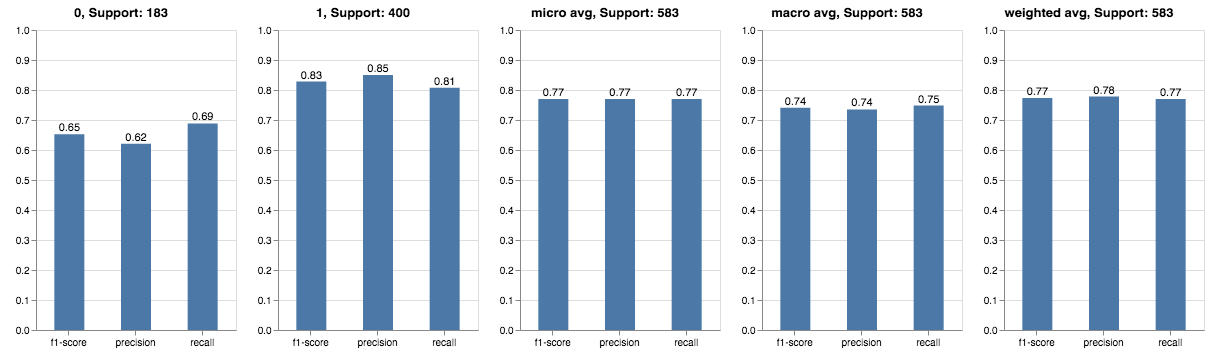

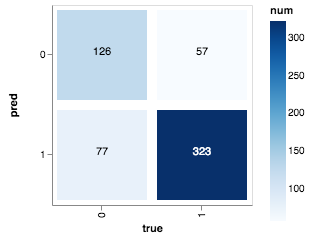

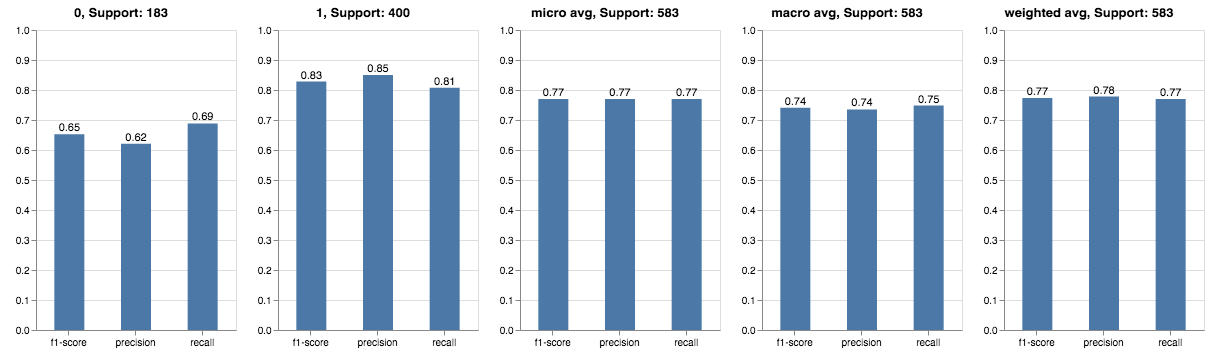

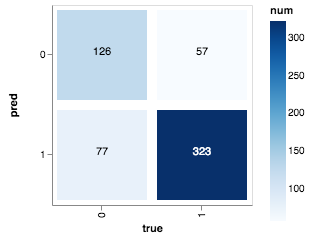

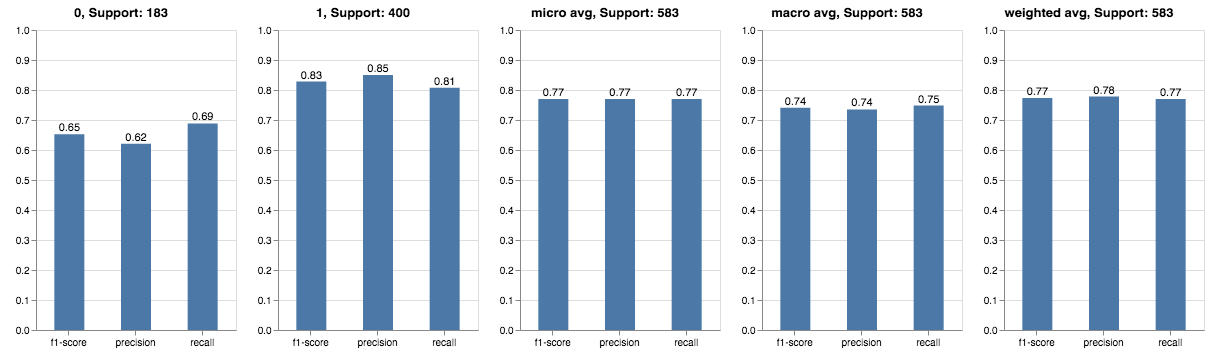

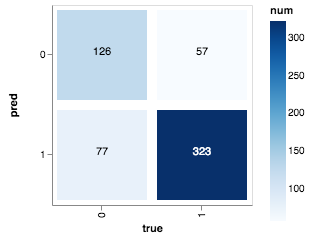

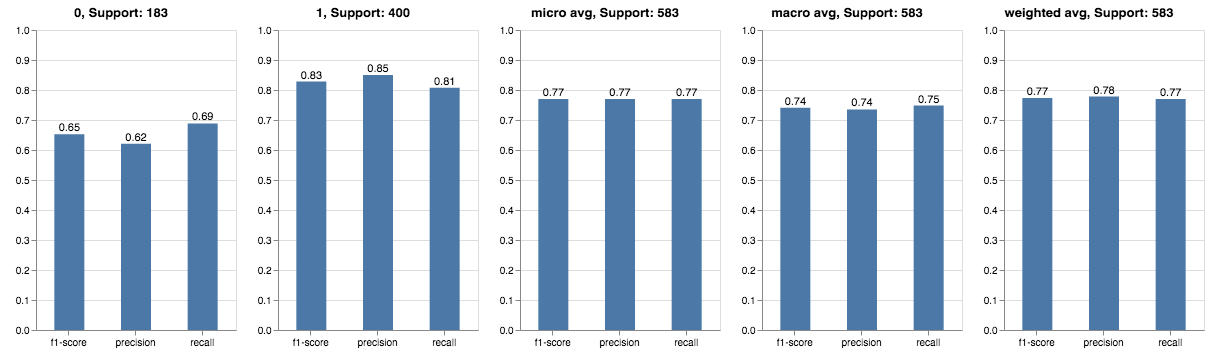

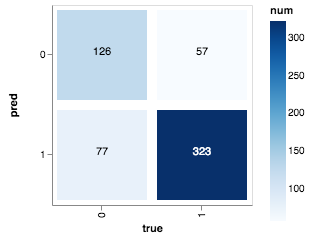

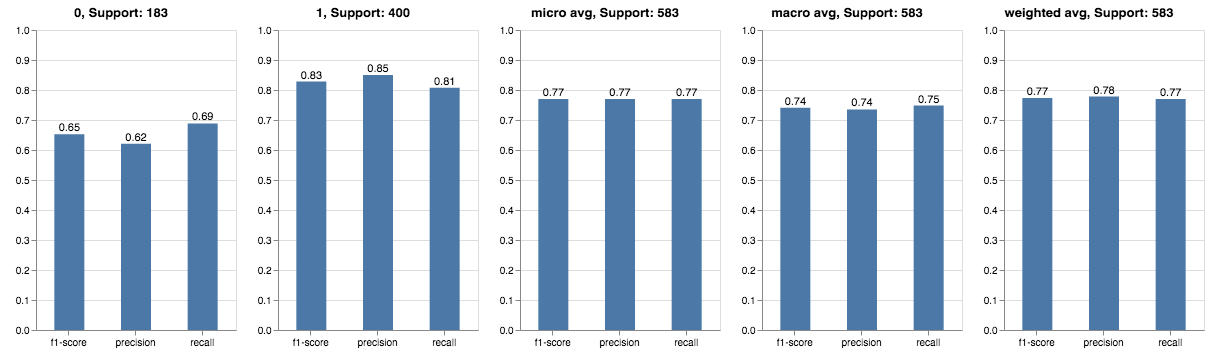

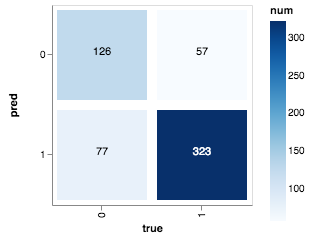

In [15]:
news_utils.plot.all(learn)

In [23]:
preds, y_true = learn.get_preds(ordered=True)

In [24]:
 _, y_pred = preds.max(dim=1)

In [34]:
root_i = []
other_i = []

for i, d in enumerate(learn.data.valid_ds):
    if 'xx_headline_start' in str(d[0]):
        root_i.append(i)
    else:
        other_i.append(i)

In [39]:
sklearn.metrics.classification_report([x for i, x in enumerate(y_true) if i in root_i], [x for i, x in enumerate(y_pred) if i in root_i], output_dict=True)

/home/group7/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7},
 '1': {'precision': 0.9278350515463918,
  'recall': 1.0,
  'f1-score': 0.9625668449197862,
  'support': 90},
 'micro avg': {'precision': 0.9278350515463918,
  'recall': 0.9278350515463918,
  'f1-score': 0.9278350515463918,
  'support': 97},
 'macro avg': {'precision': 0.4639175257731959,
  'recall': 0.5,
  'f1-score': 0.4812834224598931,
  'support': 97},
 'weighted avg': {'precision': 0.8608778828780954,
  'recall': 0.9278350515463918,
  'f1-score': 0.8931032581729975,
  'support': 97}}

In [40]:
sklearn.metrics.classification_report([x for i, x in enumerate(y_true) if not i in root_i], [x for i, x in enumerate(y_pred) if not i in root_i], output_dict=True)

{'0': {'precision': 0.6206896551724138,
  'recall': 0.7159090909090909,
  'f1-score': 0.6649076517150396,
  'support': 176},
 '1': {'precision': 0.823321554770318,
  'recall': 0.7516129032258064,
  'f1-score': 0.7858347386172007,
  'support': 310},
 'micro avg': {'precision': 0.7386831275720165,
  'recall': 0.7386831275720165,
  'f1-score': 0.7386831275720165,
  'support': 486},
 'macro avg': {'precision': 0.7220056049713659,
  'recall': 0.7337609970674487,
  'f1-score': 0.7253711951661201,
  'support': 486},
 'weighted avg': {'precision': 0.7499404553274556,
  'recall': 0.7386831275720165,
  'f1-score': 0.7420422133192988,
  'support': 486}}

In [164]:
learn.data.valid_ds[2]

(Text xxbos xx_thread_start xx_comment_start xxmaj just because you 're poor does n't mean you have to live like you 're garbage . xxmaj it proves that it 's not economics but education that gets one out of the slums and ghettos . xxmaj you could throw away a million dollars on these parents and their home would still look like trash . xx_comment_end xx_comment_start xxmaj absolutely , but i think we need to add healthcare , too . xxmaj these parents sound as though they have some mental health or substance abuse problems . xxmaj nobody chooses to live ( or have their children live ) like that out of just laziness . xx_comment_end xx_comment_start xxmaj poor people do n't have what they have .. xxmaj they were poor in their mind , def xx_comment_end xx_thread_end,
 Category 1)

In [165]:
def cut(text):
    start_token = 'xx_comment_start'
    end = 'xx_comment_end xx_thread_end'
    i = text.rindex(start_token)
    return text[:i -1], text[i + len(start_token):-len(end)]

In [50]:


idx = 0
conf = []
for i, (x, y) in enumerate(zip(res[0], res[1])):
    if np.argmax(x) != y:
        conf.append([i, max(x), y.item()])

In [51]:
learn.data.valid_ds[0][0].text

"xxbos xx_thread_start xx_comment_start xxmaj just because you 're poor does n't mean you have to live like you 're garbage . xxmaj it proves that it 's not economics but education that gets one out of the slums and ghettos . xxmaj you could throw away a million dollars on these parents and their home would still look like trash . xx_comment_end xx_thread_end"